In [ ]:
import warnings
warnings.filterwarnings('ignore')
!pip install mlxtend

In [ ]:
from __future__ import division, print_function, unicode_literals

%matplotlib inline

from pathlib import Path
import os, sys
import numpy as np

from numpy.random import choice
import pandas as pd
from scipy.stats import spearmanr

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
## 1.Setup
#First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:
# To support both python 2 and python 3
import warnings
warnings.filterwarnings("ignore")
# Common imports
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from matplotlib import pyplot
from pandas import DataFrame

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
from pathlib import Path
import requests
from io import BytesIO
from zipfile import ZipFile, BadZipFile

import numpy as np
import pandas as pd
import pandas_datareader.data as web

In [ ]:
import yfinance as yf
import pandas as pd

# Define securities with Yahoo Finance tickers
securities = {
    'BTC-USD': 'Bitcoin (USD)',
    '^GSPC': 'S&P 500 Index',
    'DX-Y.NYB': 'DXY - US Dollar Index',
    'CL=F': 'Crude Oil (WTI)',
    'GC=F': 'Gold Futures',
    '^VIX': 'Volatility Index (VIX)',
    'EURUSD=X': 'EUR/USD Exchange Rate',
    'JPY=X': 'USD/JPY Exchange Rate',
    '^IXIC': 'NASDAQ Composite',
    'TSLA': 'Tesla Stock'
}

# Download data from Yahoo Finance with a start date likely to have data for all
df = yf.download(list(securities.keys()), start="2015-01-01")['Adj Close']
df = df.rename(columns=securities).dropna(how='all').resample('B').mean()  # Resample to business days
df = df.dropna()  # Drop rows with any missing data to ensure all securities have values
# Make datetime index timezone-unaware
df.index = df.index.tz_localize(None)

df.head()


[*********************100%***********************]  10 of 10 completed


Ticker,Bitcoin (USD),Crude Oil (WTI),DXY - US Dollar Index,EUR/USD Exchange Rate,Gold Futures,USD/JPY Exchange Rate,Tesla Stock,S&P 500 Index,NASDAQ Composite,Volatility Index (VIX)
Date,,,,,,,,,,
2015-01-02,286.769674,52.689999,91.080002,1.208941,1186.000000,119.870003,14.620667,2058.199951,4726.810059,17.790001
2015-01-05,274.473999,50.040001,91.379997,1.194643,1203.900024,120.433998,14.006000,2020.579956,4652.569824,19.920000
2015-01-06,286.188995,47.930000,91.500000,1.193902,1219.300049,119.425003,14.085333,2002.609985,4592.740234,21.120001
2015-01-07,294.337006,48.650002,91.889999,1.187536,1210.599976,118.672997,14.063333,2025.900024,4650.470215,19.309999
2015-01-08,283.348999,48.790001,92.370003,1.183600,1208.400024,119.289001,14.041333,2062.139893,4736.189941,17.010000


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
np.random.seed(42)

def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'


class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [ ]:
df.columns

Index(['Bitcoin (USD)', 'Crude Oil (WTI)', 'DXY - US Dollar Index',
       'EUR/USD Exchange Rate', 'Gold Futures', 'USD/JPY Exchange Rate',
       'Tesla Stock', 'S&P 500 Index', 'NASDAQ Composite',
       'Volatility Index (VIX)'],
      dtype='object', name='Ticker')

In [ ]:
df.head()

Ticker,Bitcoin (USD),Crude Oil (WTI),DXY - US Dollar Index,EUR/USD Exchange Rate,Gold Futures,USD/JPY Exchange Rate,Tesla Stock,S&P 500 Index,NASDAQ Composite,Volatility Index (VIX)
Date,,,,,,,,,,
2015-01-02,286.769674,52.689999,91.080002,1.208941,1186.000000,119.870003,14.620667,2058.199951,4726.810059,17.790001
2015-01-05,274.473999,50.040001,91.379997,1.194643,1203.900024,120.433998,14.006000,2020.579956,4652.569824,19.920000
2015-01-06,286.188995,47.930000,91.500000,1.193902,1219.300049,119.425003,14.085333,2002.609985,4592.740234,21.120001
2015-01-07,294.337006,48.650002,91.889999,1.187536,1210.599976,118.672997,14.063333,2025.900024,4650.470215,19.309999
2015-01-08,283.348999,48.790001,92.370003,1.183600,1208.400024,119.289001,14.041333,2062.139893,4736.189941,17.010000


In [ ]:
data = df.copy()

target = "Bitcoin (USD)" # what to predict
data["target"] = data[target]
data = data.drop(target,axis=1)
data.head()

Ticker,Crude Oil (WTI),DXY - US Dollar Index,EUR/USD Exchange Rate,Gold Futures,USD/JPY Exchange Rate,Tesla Stock,S&P 500 Index,NASDAQ Composite,Volatility Index (VIX),target
Date,,,,,,,,,,
2015-01-02,52.689999,91.080002,1.208941,1186.000000,119.870003,14.620667,2058.199951,4726.810059,17.790001,286.769674
2015-01-05,50.040001,91.379997,1.194643,1203.900024,120.433998,14.006000,2020.579956,4652.569824,19.920000,274.473999
2015-01-06,47.930000,91.500000,1.193902,1219.300049,119.425003,14.085333,2002.609985,4592.740234,21.120001,286.188995
2015-01-07,48.650002,91.889999,1.187536,1210.599976,118.672997,14.063333,2025.900024,4650.470215,19.309999,294.337006
2015-01-08,48.790001,92.370003,1.183600,1208.400024,119.289001,14.041333,2062.139893,4736.189941,17.010000,283.348999


## Data preprocessing

In [ ]:
data.index.name ="date"
data.head()

Ticker,Crude Oil (WTI),DXY - US Dollar Index,EUR/USD Exchange Rate,Gold Futures,USD/JPY Exchange Rate,Tesla Stock,S&P 500 Index,NASDAQ Composite,Volatility Index (VIX),target
date,,,,,,,,,,
2015-01-02,52.689999,91.080002,1.208941,1186.000000,119.870003,14.620667,2058.199951,4726.810059,17.790001,286.769674
2015-01-05,50.040001,91.379997,1.194643,1203.900024,120.433998,14.006000,2020.579956,4652.569824,19.920000,274.473999
2015-01-06,47.930000,91.500000,1.193902,1219.300049,119.425003,14.085333,2002.609985,4592.740234,21.120001,286.188995
2015-01-07,48.650002,91.889999,1.187536,1210.599976,118.672997,14.063333,2025.900024,4650.470215,19.309999,294.337006
2015-01-08,48.790001,92.370003,1.183600,1208.400024,119.289001,14.041333,2062.139893,4736.189941,17.010000,283.348999


<Axes: xlabel='date'>

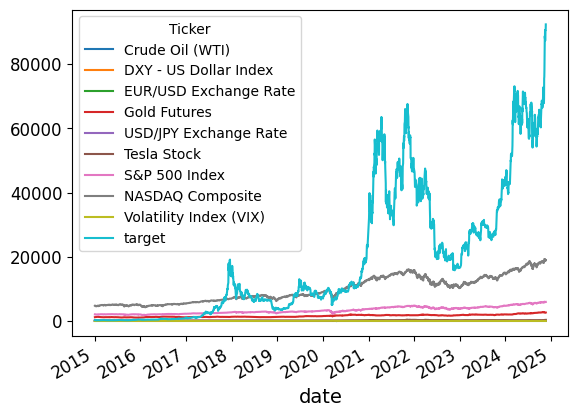

In [ ]:
data.plot()

<Axes: xlabel='date'>

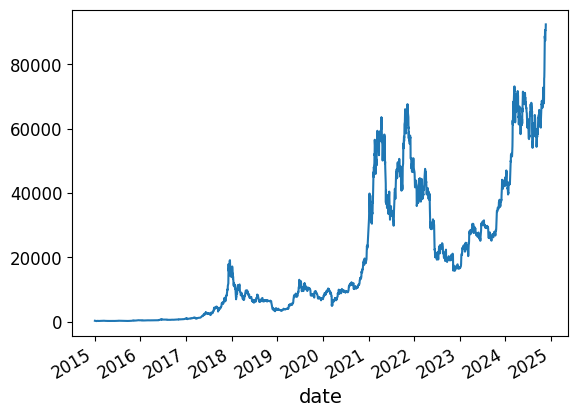

In [ ]:
data["target"].plot()

Having a plot of the data the aim now is to predict btc price in terms of the features of the dataset. First, we are going to analyse the data

In [ ]:
data.describe()

Ticker,Crude Oil (WTI),DXY - US Dollar Index,EUR/USD Exchange Rate,Gold Futures,USD/JPY Exchange Rate,Tesla Stock,S&P 500 Index,NASDAQ Composite,Volatility Index (VIX),target
count,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000
mean,61.924335,97.973755,1.119880,1592.092304,119.768153,112.739876,3328.306612,9753.493453,18.310467,19313.118283
std,18.210486,4.837982,0.052010,379.341588,15.390422,110.800350,1053.120725,4010.404605,7.314355,20746.374878
min,-37.630001,88.589996,0.959619,1050.800049,99.905998,9.578000,1829.079956,4266.839844,9.140000,178.102997
25%,48.457500,94.489998,1.085382,1261.299957,108.940002,17.130166,2429.090027,6213.979858,13.332500,2542.602539
50%,59.639999,97.199997,1.115425,1514.150024,112.771999,25.470333,2995.750000,8433.859863,16.365001,9531.667969
75%,74.110001,101.637499,1.157639,1864.074982,129.713501,218.602497,4186.407715,13334.925293,21.377500,30461.954102
max,123.699997,114.110001,1.251001,2788.500000,161.606995,409.970001,6001.350098,19298.759766,82.690002,92343.789062


We can observe that the magnitude of the different features is different, that is why we must scale the data befores applying a machine learning model

In [ ]:
# we want to predict btc in t with the values of the features in t-1
data["target"] = data["target"].shift(-1)

In [ ]:
# checking for null values
print(data.isnull().sum())


Ticker
Crude Oil (WTI)           0
DXY - US Dollar Index     0
EUR/USD Exchange Rate     0
Gold Futures              0
USD/JPY Exchange Rate     0
Tesla Stock               0
S&P 500 Index             0
NASDAQ Composite          0
Volatility Index (VIX)    0
target                    1
dtype: int64


We only have one null value in variable target. This is intentional because we wanted to create a time series dataset to forecast the price of bitcoin based on the features's past values. So, we havce to drop the last row in order to not have any n/a for the future training of the model

In [ ]:
# we have to drop the last instance in order to not having any n/a
data = data.iloc[:-1]

## Scaling data

In [ ]:
from sklearn.preprocessing import StandardScaler

target = data['target']
index = data.index

features = data.drop(columns=['target'])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

scaled_data = pd.DataFrame(scaled_features, columns=features.columns, index=index)

scaled_data['target'] = target



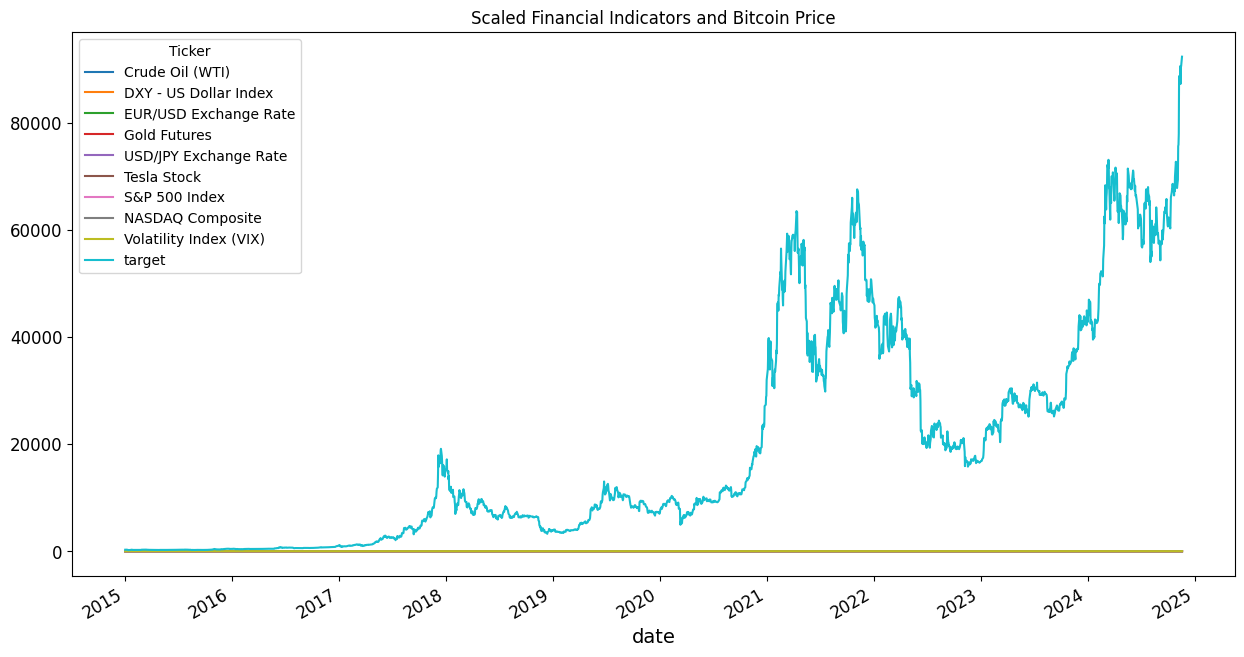

In [ ]:
scaled_data.plot(figsize=(15, 8))
plt.title("Scaled Financial Indicators and Bitcoin Price")
plt.show()

In [ ]:
scaled_data.head()

Ticker,Crude Oil (WTI),DXY - US Dollar Index,EUR/USD Exchange Rate,Gold Futures,USD/JPY Exchange Rate,Tesla Stock,S&P 500 Index,NASDAQ Composite,Volatility Index (VIX),target
date,,,,,,,,,,
2015-01-02,-0.506941,-1.425070,1.712378,-1.071028,0.007538,-0.885493,-1.206521,-1.253823,-0.071266,274.473999
2015-01-05,-0.652466,-1.363026,1.437395,-1.023770,0.044222,-0.891045,-1.242287,-1.272355,0.219946,286.188995
2015-01-06,-0.768338,-1.338207,1.423130,-0.983112,-0.021406,-0.890329,-1.259371,-1.287290,0.384010,294.337006
2015-01-07,-0.728798,-1.257548,1.300700,-1.006081,-0.070318,-0.890527,-1.237229,-1.272879,0.136547,283.348999
2015-01-08,-0.721110,-1.158274,1.225010,-1.011889,-0.030252,-0.890726,-1.202775,-1.251482,-0.177907,276.954661


In [ ]:
# Separate the target variable and the features
y = scaled_data['target']
X = scaled_data.drop(columns=['target'])  # Drop the target column from the features


# Split data into test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
X_train.head()

Ticker,Crude Oil (WTI),DXY - US Dollar Index,EUR/USD Exchange Rate,Gold Futures,USD/JPY Exchange Rate,Tesla Stock,S&P 500 Index,NASDAQ Composite,Volatility Index (VIX)
date,,,,,,,,,
2021-03-10,0.138314,-1.278229,1.344068,0.342752,-0.726989,0.994034,0.543380,0.828498,0.580886
2017-10-06,-0.693653,-0.862523,0.987193,-0.845034,-0.454005,-0.802645,-0.739595,-0.788692,-1.184162
2019-09-05,-0.308697,0.090911,-0.315546,-0.201375,-0.873466,-0.879308,-0.333952,-0.407612,-0.279080
2018-06-12,0.243751,-0.862523,1.106010,-0.782992,-0.609327,-0.811142,-0.513780,-0.510715,-0.816387
2023-11-24,0.747873,1.122936,-0.562978,1.083831,1.943535,1.109329,1.171357,1.123552,-0.799981


In [ ]:
y_train.head()

,target
date,
2021-03-10,57805.121094
2017-10-06,4772.020020
2019-09-05,10437.277995
2018-06-12,6349.899902
2023-11-24,37254.167969


## Initial model selection: Random Forest

Since we are working on a regression problem to predict the continuous price of Bitcoin, we need regression metrics to assess model quality. Two essential metrics are Mean Squared Error (MSE) and R-squared (R²):

- Mean Squared Error (MSE): MSE calculates the average squared difference between actual and predicted values, with lower values indicating more accurate predictions. This metric penalizes larger errors, so it highlights models that avoid large deviations in predictions.

- R-squared (R²): R², or the coefficient of determination, shows how much of the variance in Bitcoin’s price is explained by the model. An R² value close to 1 indicates a strong fit, meaning the model effectively captures the relationship between features and the target variable.

### Fit Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Fit the model to the training data
rf_clf = RandomForestRegressor(n_estimators=25, random_state=3, max_leaf_nodes=700)
rf_clf.fit(X_train, y_train)


RandomForestRegressor(max_leaf_nodes=700, n_estimators=25, random_state=3)

In [ ]:
# Predict on the training data and calculate evaluation metrics
y_pred_train = rf_clf.predict(X_train)
print("In-sample MSE:", mean_squared_error(y_train, y_pred_train))
print("In-sample MAE:", mean_absolute_error(y_train, y_pred_train))
print("In-sample R²:", r2_score(y_train, y_pred_train))

In-sample MSE: 621021.2392382319
In-sample MAE: 377.19525331992816
In-sample R²: 0.9985547167820775


In [ ]:
# Predict on the test data and calculate evaluation metrics
y_pred_test = rf_clf.predict(X_test)
print("Out-of-sample MSE:", mean_squared_error(y_test, y_pred_test))
print("Out-of-sample MAE:", mean_absolute_error(y_test, y_pred_test))
print("Out-of-sample R²:", r2_score(y_test, y_pred_test))

Out-of-sample MSE: 4471213.547270383
Out-of-sample MAE: 1046.7896464796715
Out-of-sample R²: 0.9896496042716298


An R-squared of 0.987 out of sample indicates that the model explains approximately 98.7% of the variation in Bitcoin's price using the predictor variables included. This is an exceptionally high value, suggesting that the model has strong explanatory power: nearly all observed variation in Bitcoin’s price can be attributed to the variables used in the model.

This R² level means that the selected features are highly correlated with changes in Bitcoin’s price, and the model is able to capture most of the fluctuations or trends in the target variable.








### Fit Random Forest using Cross Validation


We will now apply cross-validation to train the model. *Cross-validation* is a technique that splits the data into multiple subsets or "folds" and trains the model on different combinations of these folds, testing on the remaining folds each time. This process helps ensure that the model generalizes well to new data, as it is exposed to a variety of training and testing scenarios. By using cross-validation, I aim to reduce overfitting and obtain a more reliable evaluation of the model’s performance across different subsets of the data.

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score
import numpy as np

# Initialize KFold with a specified number of splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Custom scorer to ignore R-squared scores outside [0, 1]
def custom_r2(y_true, y_pred):
    score = r2_score(y_true, y_pred)
    return score if 0 <= score <= 1 else np.nan  # Return NaN for scores out of range

# Set up the scorer
scorer = make_scorer(custom_r2, greater_is_better=True)

# Perform cross-validation
r2_scores = cross_val_score(rf_clf, X_train, y_train, cv=kf, scoring=scorer)

# Filter out any NaN scores from invalid R-squared values
valid_r2_scores = r2_scores[~np.isnan(r2_scores)]

# Calculate the average R-squared score for valid folds
if len(valid_r2_scores) > 0:
    avg_r2 = np.mean(valid_r2_scores)
    print(f"R-squared scores for each fold: {valid_r2_scores}")
    print(f"Average R-squared: {avg_r2}")
else:
    print("No valid R-squared scores to average.")

R-squared scores for each fold: [0.98983222 0.99061615 0.98755335 0.98901911 0.98731533]
Average R-squared: 0.9888672324422743


### Hyperparameter Tuning

The key configuration parameters include the various hyperparameters for the individual decision trees introduced in the notebook [decision_trees](01_decision_trees.ipynb).

The following tables lists additional options for the two `RandomForest` classes:

| Keyword      | Default | Description                                                                                                                |
|--------------|---------|----------------------------------------------------------------------------------------------------------------------------|
| bootstrap    | True    | Bootstrap samples during training                                                                                          |
| n_estimators | 10      | # trees in the forest.                                                                                                     |
| oob_score    | False   | Use out-of-bag samples to estimate the R2 on unseen data                                                                   |
| warm_start   | False   | Reuse result of previous call to continue training and add more trees to the ensemble, otherwise, train a whole new forest |

- The `bootstrap` parameter activates in the preceding bagging algorithm outline, which in turn enables the computation of the out-of-bag score (oob_score) that estimates the generalization accuracy using samples not included in the bootstrap sample used to train a given tree (see next section for detail).
- The `n_estimators` parameter defines the number of trees to be grown as part of the forest. Larger forests perform better, but also take more time to build. It is important to monitor the cross-validation error as a function of the number of base learners to identify when the marginal reduction of the prediction error declines and the cost of additional training begins to outweigh the benefits.
- The `max_features` parameter controls the size of the randomly selected feature subsets available when learning a new decision rule and split a node. A lower value reduces the correlation of the trees and, thus, the ensemble's variance, but may also increase the bias. Good starting values are `n_features` (the number of training features) for regression problems and `sqrt(n_features)` for classification problems, but will depend on the relationships among features and should be optimized using cross-validation.

Random forests are designed to contain deep fully-grown trees, which can be created using `max_depth=None` and `min_samples_split=2`. However, these values are not necessarily optimal, especially for high-dimensional data with many samples and, consequently, potentially very deep trees that can become very computationally-, and memory-, intensive.

The `RandomForest` class provided by sklearn support parallel training and prediction by setting the n_jobs parameter to the k number of jobs to run on different cores. The -1 value uses all available cores. The overhead of interprocess communication may limit the speedup from being linear so that k jobs may take more than 1/k the time of a single job. Nonetheless, the speedup is often quite significant for large forests or deep individual trees that may take a meaningful amount of time to train when the data is large, and split evaluation becomes costly.

As always, the best parameter configuration should be identified using cross-validation. The following steps illustrate the process:

#### Define Parameter Grid

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],         # Number of trees in the forest
    'max_depth': [20, 30, 50],         # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],             # Minimum number of samples required to split a node
}


#### Grid Search

We will use 10-fold custom cross-validation and populate the parameter grid with values for the key configuration settings:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Create the model
rf = RandomForestRegressor()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best R-squared score:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 50}
Best R-squared score: 0.9898012245301956


## Feature importance

### Lasso regression for feature importance

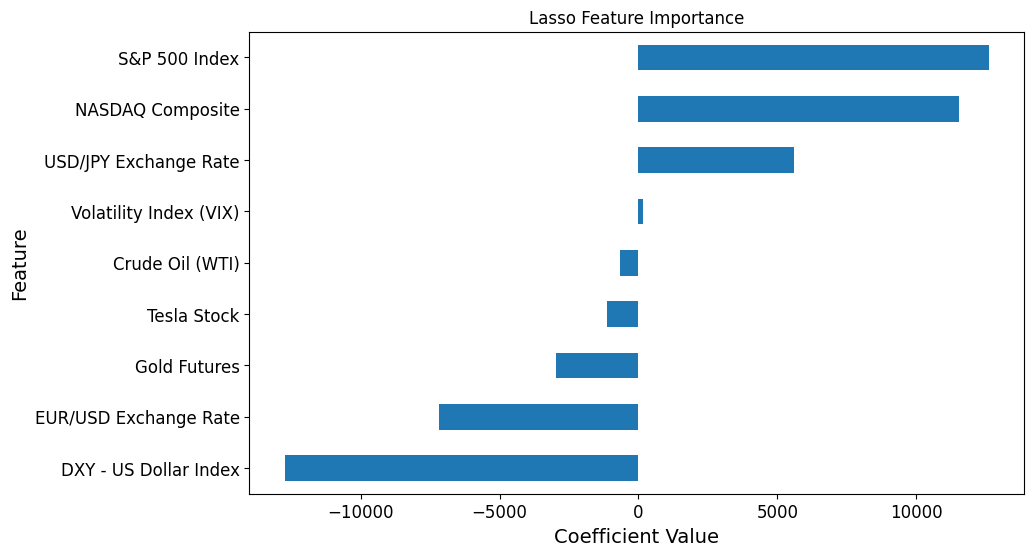

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

coef_df = pd.Series(lasso.coef_, index=X.columns)
important_features = coef_df[coef_df != 0].sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
important_features.plot(kind='barh', ax=ax, title='Lasso Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


Lasso regression assigns each feature a coefficient that indicates its importance in the prediction. Thanks to its penalty, Lasso forces some coefficients to be zero, thus eliminating less important features. By visualizing the non-zero coefficients, we can interpret which features are more relevant to the model. The larger coefficients in magnitude represent features that have a greater impact on predicting the price of Bitcoin, while zero coefficients indicate that the feature was discarded for being less useful in the model.


Bitcoin prices are heavily influenced by speculation, and investors often look at the performance of traditional markets (such as the Nasdaq and the S&P 500) to adjust their investment decisions. During certain periods, if stock markets are rising, there may be a positive effect on the demand for high-risk assets like cryptocurrencies, which explains why these indices can be highly relevant for predicting the price of Bitcoin.

We observe that the majority of the features do not contribute so much to the prediction of bitcoin price. However, the NASDAQ index has a great relevance in this model .

The value of the NASDAQ Index (most relevant feature) can serve as a good predictor of Bitcoin prices for several reasons, mainly due to its close association with technology stocks, risk appetite, and investor sentiment:

- Technology-Driven Investor Sentiment: The NASDAQ index heavily represents technology stocks, and its performance is often driven by the overall sentiment toward innovation and tech investments. Bitcoin, as a digital asset associated with technological advancements and innovation, tends to draw interest from the same investor base, so fluctuations in the NASDAQ may reflect similar sentiment changes in the cryptocurrency market.

- Market Liquidity and Risk Appetite: Investors often view Bitcoin and tech stocks as high-risk, high-reward assets. When the NASDAQ performs well, it typically signals a broader risk-on environment where investors are more willing to invest in volatile assets like Bitcoin. Conversely, a downturn in NASDAQ can indicate a shift toward safer investments, potentially leading to reduced interest in Bitcoin.

- Macro-economic Influence: Both Bitcoin and the NASDAQ are influenced by broader economic conditions, such as interest rates and inflation expectations. For instance, in times of low interest rates and high liquidity, both markets may experience bullish trends, as investors seek alternative investments outside of traditional bonds and savings.

- Correlation and Institutional Investment: With increasing institutional investment in both technology stocks and Bitcoin, there's a growing correlation between NASDAQ performance and Bitcoin prices. Many institutional funds diversify into both assets as part of a balanced risk portfolio, meaning trends in the NASDAQ can have spillover effects on Bitcoin.

Regarding the US Dolar Index: lthough Bitcoin is primarily viewed as a speculative asset, many investors also consider it a hedge against inflation and the devaluation of the dollar. When the dollar weakens, investors may move their capital into Bitcoin in an attempt to protect its value from the loss of purchasing power of the dollar. For this reason, when the dollar weakens (DXY index falls), the price of Bitcoin tends to rise, as it is seen as an alternative store of value.

## Additional model: LSTM (Long Short-Term Memory) Neural Network

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

#### Building the Neural Network model

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

### Fit Neural Network

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32)

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 762918016.0000 - mae: 18561.4941 - val_loss: 911120960.0000 - val_mae: 21225.9512
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 797724480.0000 - mae: 18981.6719 - val_loss: 894256192.0000 - val_mae: 21001.1719
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 751126848.0000 - mae: 18299.3184 - val_loss: 797268800.0000 - val_mae: 19740.3164
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 630818048.0000 - mae: 16647.2266 - val_loss: 526169664.0000 - val_mae: 15870.2988
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 374635904.0000 - mae: 12519.9551 - val_loss: 195527424.0000 - val_mae: 9553.6602
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 149923584.0000 - mae: 7946.0698 - val_loss: 84909432.0000 - val_mae: 6232.7983
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86738560.0000 - mae: 6129.5894 - val_loss: 56584016.0000 - val_mae: 5157.7949
Epoch 8/100
47/47 ━━━

### Predictions

In [ ]:
# Evaluar el modelo en el conjunto de prueba
predictions = model.predict(X_test)
loss, mae = model.evaluate(X_test, y_test)
r2 = r2_score(y_test, predictions)
print(f"Mean Absolute Error on test set: {mae}")
print(f"R-squared (R²): {r2}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23640514.0000 - mae: 2898.0559 
Mean Absolute Error on test set: 3020.026611328125
R-squared (R²): 0.9405607804439001


In [ ]:
print(predictions)

[[  584.1354  ]
 [ 2563.2185  ]
 [51112.277   ]
 [37993.207   ]
 [ 9999.901   ]
 [44018.86    ]
 [ 9032.931   ]
 [16636.314   ]
 [32615.326   ]
 [ 1346.0077  ]
 [ 6309.901   ]
 [ 2210.7756  ]
 [21964.37    ]
 [42837.754   ]
 [11548.022   ]
 [  150.22467 ]
 [ 3352.798   ]
 [  230.60551 ]
 [19215.617   ]
 [ 9591.075   ]
 [48409.77    ]
 [35219.99    ]
 [ 8340.294   ]
 [58496.477   ]
 [41286.895   ]
 [ 9204.926   ]
 [19178.064   ]
 [10260.085   ]
 [ 7344.5874  ]
 [   99.9031  ]
 [ 5022.4824  ]
 [  134.8575  ]
 [ 8216.301   ]
 [34590.13    ]
 [37294.723   ]
 [ 2771.7202  ]
 [ 6024.155   ]
 [ 9410.505   ]
 [ 5996.475   ]
 [34737.785   ]
 [52207.34    ]
 [20110.59    ]
 [  599.74097 ]
 [44174.324   ]
 [14207.121   ]
 [ 2415.812   ]
 [12437.969   ]
 [ 1550.5912  ]
 [23870.37    ]
 [32585.629   ]
 [52739.258   ]
 [ 7513.99    ]
 [20089.607   ]
 [32735.643   ]
 [  207.01173 ]
 [ 5248.3516  ]
 [73417.62    ]
 [  138.76424 ]
 [ 5772.313   ]
 [48332.082   ]
 [21624.994   ]
 [ 7909.319   ]
 [ 1729.

# Additional: PCA

If we want to make a visualization of the performance of the model, we will have to reduce the number of dimensions in order to have an understandable chart.

Explained variance by each component: [0.57419795 0.20474576]
Total explained variance: 0.7789437110294388


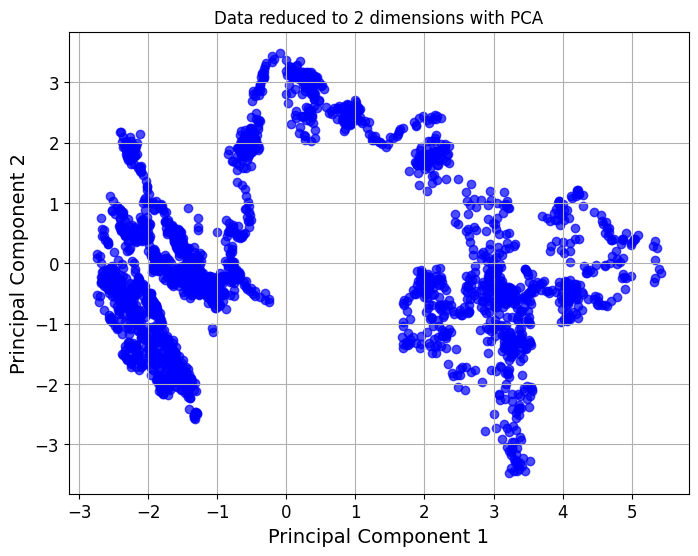

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)  # Transform data to 2 principal components


pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])


explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by each component: {explained_variance}')
print(f'Total explained variance: {sum(explained_variance)}')

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, c='blue')
plt.title('Data reduced to 2 dimensions with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

After performing PCA to reduce the dataset to two dimensions, I obtained the following results:

Explained variance by PC1: 57.42%
Explained variance by PC2: 20.47%
Total explained variance: 77.89%
These results indicate that the first principal component (PC1) captures the majority of the variance, making it the most important direction in the dataset. However, the second principal component (PC2) also contributes significantly, adding an additional 20.47% of the variance. Together, these two components explain 77.89% of the total variability, which is a substantial portion of the original data.

This suggests that reducing the dataset to two dimensions provides a good balance between dimensionality reduction and retaining meaningful information. However, approximately 22.11% of the variance is not accounted for, which may be important depending on the context of the analysis.

To further interpret these results:

I would visualize the data in the reduced 2D space to assess how well the structure of the data is preserved.
I could examine the contributions of the third and subsequent components to decide if they hold critical information that might justify a higher-dimensional representation.
Overall, this PCA analysis shows that the dataset has significant variability captured by at least two dimensions, supporting the decision to reduce to 2D for a simplified yet informative representation.



In [ ]:
pca_df.head()

,PC1,PC2
0,-2.685755,0.755064
1,-2.634393,0.558520
2,-2.672257,0.569699
3,-2.639716,0.447813
4,-2.579768,0.322090


In [ ]:
X = pca_df[['PC1', 'PC2']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Squared Error (MSE): 8117068.4182
R-squared (R2): 0.9808
